# LIME and DiCE explainers for XGBoost on Prostate cancer dataset

Prediction of prostate cancer, and Explanation of the prediction.

# 0. About Prostate cancer

### What is the prostate cancer?

Prostate cancer develops when abnormal cells in the prostate gland grow uncontrolled, forming a malignant tumor. Prostate cancer is the second most commonly diagnosed cancer in men, with an estimated 1.4 million diagnoses worldwide in 2020*.

*Culp, M.B., et al. Recent Global Patterns in Prostate Cancer Incidence and Mortality Rates. Eur Urol, 2020. 77: 38.
https://pubmed.ncbi.nlm.nih.gov/31493960/

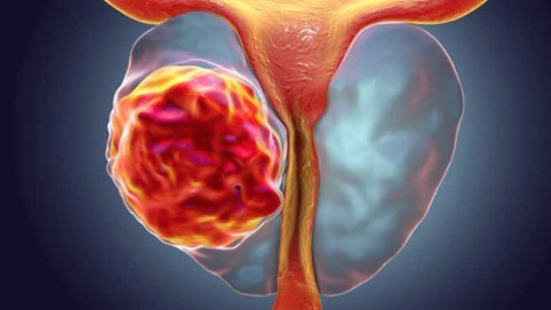

# 1. Preparation

In [1]:
#!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn lime xgboost protobuf


In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import google.protobuf

# For prediction of ML
import xgboost as xgb

# Helper libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # Show all columns in print

# Stats
from scipy.stats import loguniform
import seaborn as sns
import math

# For i/o
import os
import io
#from google.colab import files

# For warnings
import warnings

# DiCE
import dice_ml
# from dice_ml import Dice

c:\Users\ulfle\anaconda3\lib\site-packages\dice_ml\utils\exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [3]:
# Check version of XGBoost
print(xgb.__version__)

2.0.0


In [4]:
# Suppress XGBoost FutureWarnings (for not clogging the page)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# Install LIME
!pip install lime
# Alternatively if not work: !apt-get install -y python-lime


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Import the Local Surrogate LIME
import lime
import lime.lime_tabular
from lime import submodular_pick

# 2. Dataset analysis and cleaning

The data set consists of 100 observations and 10 variables (out of which 8 are numeric variables and 1 categorical variable, plus ID)

### 2.1 Let's look at the dataset

https://www.kaggle.com/datasets/sajidsaifi/prostate-cancer

### Features in Dataset
- There are 9 features, including the classifier

Variables
- `Radius` (9 – 25) mm. (Mean of distances from center to points on the perimeter)
- `Texture` (11 – 27) no unit. (Standard deviation of gray-scale values)
- `Perimeter` (52 – 182) mm  (Perimeter measurement of prostate cancer)
- `Area` (202 – 1878) mm2
- `Smoothness` (0.07 – 0.143) no unit. (Local variation in radius lengths)
- `Compactness` (0.038 – 0.345) no unit (perimeter^2 / area - 1.0)
- `Symmetry` (0.135 – 0.304) no unit
- `Fractal dimension` (0.053 – 0.097) no unit ("coastline approximation" - 1)

Prediction
- `diagnosis_result` (M/B) Malignant / Benign



M/B describe the level of cancer. If the cancer region is localised, has defined boundary and isn't spreading then it is called as **benign** ("harmless"). If the cancer region is generalised, has abnormal shape and boundary, and spreads at a rapid pace then it is called as **malignant** ("harmfull").

Description of variables: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

Let's look at the dataset

In [7]:
df = pd.read_csv("Prostate_cancer.csv")  # \t = tab
df_orig = df    # Save the original dataset
df

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059
...,...,...,...,...,...,...,...,...,...,...
95,96,M,23,16,132,1264,0.091,0.131,0.210,0.056
96,97,B,22,14,78,451,0.105,0.071,0.190,0.066
97,98,B,19,27,62,295,0.102,0.053,0.135,0.069
98,99,B,21,24,74,413,0.090,0.075,0.162,0.066


In [8]:
df.head().T

,0,1,2,3,4
id,1,2,3,4,5
diagnosis_result,M,B,M,M,M
radius,23,9,21,14,9
texture,12,13,27,16,19
perimeter,151,133,130,78,135
area,954,1326,1203,386,1297
smoothness,0.143,0.143,0.125,0.07,0.141
compactness,0.278,0.079,0.16,0.284,0.133
symmetry,0.242,0.181,0.207,0.26,0.181
fractal_dimension,0.079,0.057,0.06,0.097,0.059


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [10]:
# Let's check two patients
df[25:26]

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
25,26,M,19,27,116,913,0.119,0.228,0.304,0.074


In [11]:
df[93:94]

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
93,94,B,10,17,87,555,0.102,0.082,0.164,0.057


### 2.2 Rename and remove features

Rename columns for better understanding

In [12]:
df = df.rename(columns={"diagnosis_result":"prostate"})

Remove id

In [13]:
df = df.drop("id", axis=1)

In [14]:
df

,prostate,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,M,23,12,151,954,0.143,0.278,0.242,0.079
1,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,M,14,16,78,386,0.070,0.284,0.260,0.097
4,M,9,19,135,1297,0.141,0.133,0.181,0.059
...,...,...,...,...,...,...,...,...,...
95,M,23,16,132,1264,0.091,0.131,0.210,0.056
96,B,22,14,78,451,0.105,0.071,0.190,0.066
97,B,19,27,62,295,0.102,0.053,0.135,0.069
98,B,21,24,74,413,0.090,0.075,0.162,0.066


### 2.3 Check for null values

In [15]:
# Checking if there are null values
df.isnull().sum()

prostate             0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
symmetry             0
fractal_dimension    0
dtype: int64

No missing values

### 2.4 Check for outliers

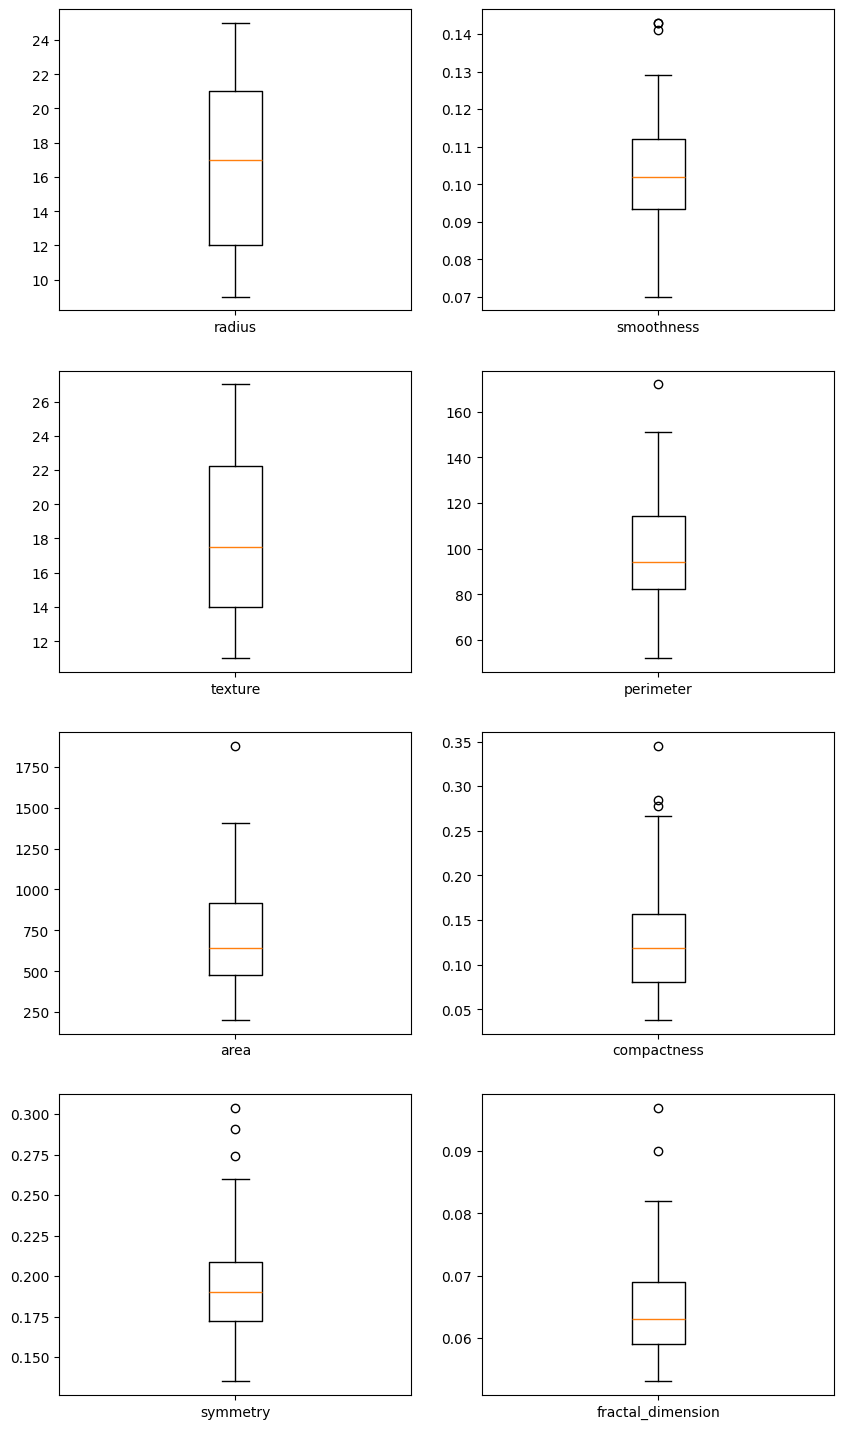

In [16]:
# Check numeric variables for outliers
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4,
                                             ncols=2,
                                             figsize=(10,18))
ax1.boxplot(df['radius'], labels=['radius']);
ax2.boxplot(df['smoothness'], labels=['smoothness']);
ax3.boxplot(df['texture'], labels=['texture']);
ax4.boxplot(df['perimeter'], labels=['perimeter']);
ax5.boxplot(df['area'], labels=['area']);
ax6.boxplot(df['compactness'], labels=['compactness']);
ax7.boxplot(df['symmetry'], labels=['symmetry']);
ax8.boxplot(df['fractal_dimension'], labels=['fractal_dimension']);

In [17]:
df.describe()

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


- Outliers seems ok, no values way out

### 2.5 Balanced dataset

Check to see if classes are evenly distributed or unbalanced (more of one class than the other)

In [18]:
# Check class balance
df["prostate"].value_counts()

prostate
M    62
B    38
Name: count, dtype: int64

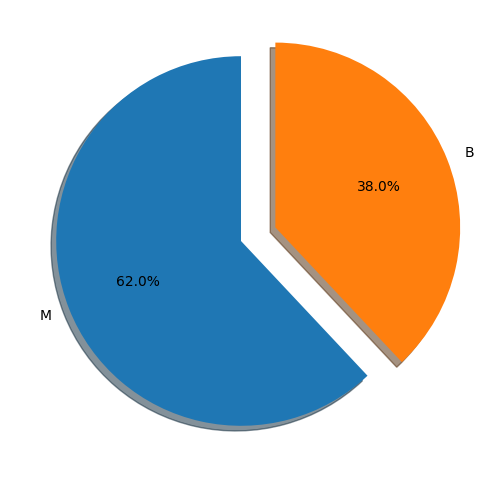

In [19]:
# Plot class balance
data_dr = df['prostate'].value_counts()

label = [data_dr.index.tolist()]
plt.pie(data_dr, labels=label[0], shadow=True, explode=(0.0, 0.2), autopct='%1.1f%%', startangle=90)
plt.gcf().set_size_inches(12,6)
plt.show()

The dataset is moderately imbalanced, which XGBoost can handle reasonably well.

As we are not so concerned about optimizing the prediction to the very maximum (as it is the *explanation* of the prediction that interests us, not the prediction itself), the imbalance can be handled by*
- Balance the positive and negative weights via scale_pos_weight
- Use AUC for evaluation

which we will do.

*xgboost developers. Handle Imbalanced Dataset. 2022 [cited 2023 Sep 21]. Notes on Parameter Tuning — xgboost 2.0.0 documentation. Available from: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset

# 3. Data Preprocessing

## 3.1 Feature selection

### 3.1.1 Correlation

Check if there are any strong correlations between features

In [20]:
# Remove classification column 
df_noClass = df.drop(columns = ['prostate'])

<Axes: >

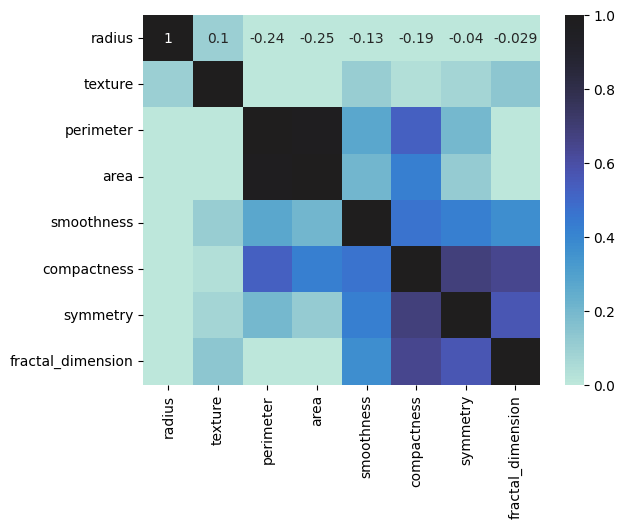

In [21]:
# Calculation the correlation for the data
sns.heatmap(df_noClass.corr(),annot=True,vmin=0, vmax=1, center=True)

Perimeter and area have a strong correlation, so elimintate one of them (perimeter) to avoid redudancy.

In [22]:
df = df.drop(columns = ['perimeter'])

In [23]:
df

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
0,M,23,12,954,0.143,0.278,0.242,0.079
1,B,9,13,1326,0.143,0.079,0.181,0.057
2,M,21,27,1203,0.125,0.160,0.207,0.060
3,M,14,16,386,0.070,0.284,0.260,0.097
4,M,9,19,1297,0.141,0.133,0.181,0.059
...,...,...,...,...,...,...,...,...
95,M,23,16,1264,0.091,0.131,0.210,0.056
96,B,22,14,451,0.105,0.071,0.190,0.066
97,B,19,27,295,0.102,0.053,0.135,0.069
98,B,21,24,413,0.090,0.075,0.162,0.066


### 3.2 One-hot encoding

### Preparing dataframes for Classification Tasks

This step is to **transform the pandas DataFrame into numerical Numpy arrays**, so that they can be processed by the packages in `sklearn`. At this stage, we need to **encode categorical features** .

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prostate           100 non-null    object 
 1   radius             100 non-null    int64  
 2   texture            100 non-null    int64  
 3   area               100 non-null    int64  
 4   smoothness         100 non-null    float64
 5   compactness        100 non-null    float64
 6   symmetry           100 non-null    float64
 7   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 6.4+ KB


No categorical features, so not needed

### 3.3 Target to number

Transform target object to int64. 1 = Malignant, 0 = Benign

In [25]:
df=df.replace({'prostate':{'M':1,'B':0}})

In [26]:
df

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
0,1,23,12,954,0.143,0.278,0.242,0.079
1,0,9,13,1326,0.143,0.079,0.181,0.057
2,1,21,27,1203,0.125,0.160,0.207,0.060
3,1,14,16,386,0.070,0.284,0.260,0.097
4,1,9,19,1297,0.141,0.133,0.181,0.059
...,...,...,...,...,...,...,...,...
95,1,23,16,1264,0.091,0.131,0.210,0.056
96,0,22,14,451,0.105,0.071,0.190,0.066
97,0,19,27,295,0.102,0.053,0.135,0.069
98,0,21,24,413,0.090,0.075,0.162,0.066


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prostate           100 non-null    int64  
 1   radius             100 non-null    int64  
 2   texture            100 non-null    int64  
 3   area               100 non-null    int64  
 4   smoothness         100 non-null    float64
 5   compactness        100 non-null    float64
 6   symmetry           100 non-null    float64
 7   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


# 4. Baseline modelling

We start XGBoost using the default parameters to have as a baseline for our optimization.

### Create X and y sets for train and test

In [28]:
# Defining feature vector and class labels
X = df.drop("prostate", axis=1)
y = df["prostate"]

In [29]:
X

,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
0,23,12,954,0.143,0.278,0.242,0.079
1,9,13,1326,0.143,0.079,0.181,0.057
2,21,27,1203,0.125,0.160,0.207,0.060
3,14,16,386,0.070,0.284,0.260,0.097
4,9,19,1297,0.141,0.133,0.181,0.059
...,...,...,...,...,...,...,...
95,23,16,1264,0.091,0.131,0.210,0.056
96,22,14,451,0.105,0.071,0.190,0.066
97,19,27,295,0.102,0.053,0.135,0.069
98,21,24,413,0.090,0.075,0.162,0.066


In [30]:
y

0     1
1     0
2     1
3     1
4     1
     ..
95    1
96    0
97    0
98    0
99    1
Name: prostate, Length: 100, dtype: int64

In [31]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We can now use the X_train, X_test, y_train, and y_test arrays in the example code to train and test the XGBoost model.

#### 4.1 We first do the calculation without adjusting for the imbalanced datset:

In [32]:
# Train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the accuracy and AUC ROC of the model
# same as xgb_model.score(X_test, y_test)
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_pred, y_test)

In [33]:
# ROC_AUC score on test dataset
roc_auc = roc_auc_score(xgb_model.predict(X_test), y_test)
print("Accuracy: ", acc)
print("ROC AUC: ", roc_auc)

Accuracy:  0.8
ROC AUC:  0.7916666666666666


- Accuracy = Number of correct decision made / Total number of decisions made = How frequent the model predicts the correct result (being Malignant or Benign)
- ROC-AUC = Indicates how well the model is capable of distinguishing between Malignant and Benign (1 = Perfect separation)

As expecteed for baseline

#### 4.2 Then we adjust for the imbalanced dataset

In [34]:
# Calculate class weights to balance the dataset
class_weight = len(y_train) / (2 * np.bincount(y_train))

In [35]:
# Calculate the scale_pos_weight based on class weights
scale_pos_weight = class_weight[0] / class_weight[1]

# The scale_pos_weight do not need to be further optimized, as it is based on the relative sizes of the classes

In [36]:
print("The scale_pos_weight is:", scale_pos_weight)

The scale_pos_weight is: 1.6666666666666665


In [37]:
# Initialize an XGBoost classifier with scale_pos_weight
xgb_model_balanced = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Train the XGBoost model
xgb_model_balanced.fit(X_train, y_train)

# Make predictions on the test set with the balanced model
y_pred_balanced = xgb_model.predict(X_test)
acc_balanced = accuracy_score(y_test, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_pred_balanced, y_test)

print("Accuracy (Not Balanced): ", acc)
print("Accuracy (Balanced): ", acc_balanced)
print()
print("ROC AUC (Not Balanced): ", roc_auc)
print("ROC AUC (Balanced): ", roc_auc_balanced)

Accuracy (Not Balanced):  0.8
Accuracy (Balanced):  0.8

ROC AUC (Not Balanced):  0.7916666666666666
ROC AUC (Balanced):  0.7916666666666666


No difference.

# 5. Optimization the hyperparameters of XGBoost

Gradient Boosted Methods builds the model based on the learnings from each new training value. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.

For gradient-boosting, parameters are coupled, so we cannot set the parameters one after the other anymore.

The parameters which we need to pay attention to when we are building and optimizing a new model are:
.
- `n_estimators` — The number of trees in the forest.
- `learning_rate` — How much each error shall impact the rest of the trees.
- `max_depth` — The maximum depth of a tree.

But also maybe look at
- `reg_lambda` — L2 regularization term on weights. It's used to avoid overfitting
- `colsample_by_tree` — Fraction of features that can be randomly sampled for building each tree.
- `subsample` — Fraction of the training data that can be randomly sampled for building each tree. 

Let’s first discuss the `max_depth` parameter. The algorithm fits the error of the previous tree in the ensemble. Thus, fitting fully grown trees would be detrimental. Indeed, the first tree of the ensemble would perfectly fit (overfit) the data and thus no subsequent tree would be required, since there would be no residuals. Therefore, the tree used in gradient-boosting should have a low depth, typically between 3 to 8 levels, or few leaves. Having very weak learners at each step will help reducing overfitting.

The deeper the trees, the faster the residuals will be corrected and less learners are required. Therefore, `n_estimators` should be increased if `max_depth` is lower.

Finally the `learning_rate` parameter. When fitting the residuals, we would like the tree to try to correct all possible errors or only a fraction of them. The `learning-rate` allows you to control this behaviour. A small `learning-rate` value would only correct the residuals of very few samples. If a large `learning-rate` is set (e.g., 1), we would fit the residuals of all samples. So, with a very low `learning-rate`, we will need more estimators to correct the overall error. However, a too large `learning-rate` tends to obtain an overfitted ensemble, similar to having a too large tree depth. `subsample` determines what fraction of the training data that can be randomly sampled for building each tree. Setting it to 0.5 means that XGBoost randomly collects half of the data instances to grow trees and this prevents overfitting.

We find the approximate values for the parameters, using RandomizedSearchCV, which picks out randomized selections of the input paramteters, and tests with Cross-Validation.

In [38]:
# Check range of best parameters with randomized search CV, 
# starting with `max_depth`, `n_estimators`, `learning_rate` and `scale_pos_weight` 

random_state=42

# Randomized parameters grid
xgb_params = {"max_depth": [5, 6, 7, 8],
                "n_estimators" : np.arange(25, 100, 25),   # .arange = Return evenly spaced values within a given interval.
                "learning_rate": loguniform(0.01, 1),
                "scale_pos_weight": [scale_pos_weight]
               }

# Instantiate RandomizedSearchCV
rs_xgb = RandomizedSearchCV(
            xgb.XGBClassifier(),
            param_distributions=xgb_params,
            cv=10,  
            n_iter=20,
            verbose=1,
            random_state=random_state
        )

# Fit to data
# No need to split data into train and test as we are using Cross Validation
rs_xgb.fit(X, y)

# Check best hyperparameters
rs_xgb.best_params_


Fitting 10 folds for each of 20 candidates, totalling 200 fits


{'learning_rate': 0.015679933916723007,
 'max_depth': 8,
 'n_estimators': 75,
 'scale_pos_weight': 1.6666666666666665}

We got

- n_estimators: 75
- learning_rate: 0.016
- max_depth: 8

In [39]:
# Continue with other parameters 

xgb_params = {"n_estimators" : [50, 75, 100], 
                "max_depth": [5, 6, 7, 8, 9],
                "learning_rate": loguniform(0.01, 1),
                "reg_lambda": np.arange(0, 1, 0.1),
                "subsample": np.arange(0.6, 1, 0.1),
                "colsample_bytree":np.arange(0.1, 1, 0.1),
                "scale_pos_weight": [scale_pos_weight]
               }

# Instantiate RandomizedSearchCV
rs_xgb = RandomizedSearchCV(
        xgb.XGBClassifier(),
        param_distributions=xgb_params,
        cv=6,   
        n_iter=100,
        verbose=1,
        random_state=random_state
    )

# Fit to data
rs_xgb.fit(X, y)

# Check best hyperparameters
rs_xgb.best_params_


Fitting 6 folds for each of 100 candidates, totalling 600 fits


{'colsample_bytree': 0.8,
 'learning_rate': 0.768810680147495,
 'max_depth': 5,
 'n_estimators': 50,
 'reg_lambda': 0.0,
 'scale_pos_weight': 1.6666666666666665,
 'subsample': 0.7}

We got

- n_estimators: 50
- max_depth: 5
- learning_rate: 0.77
- reg_lambda: 0.0
- subsample: 0.7
- colsample_bytree: 0.8

Finally ending up with GridSearch:

In [40]:
# Then with Grid Search

xgb_grid = xgb.XGBClassifier()
parameters = {
    "n_estimators": [25, 50, 75, 100],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.74, 0.75, 0.76, 0.77, 0.5, 0.02], # Trying some other values as well
    "reg_lambda": [0.0, 0.1, 0.2, 0.7, 0.8],  # Trying some other values as well
    "subsample": [0.6, 0.65, 0.70],
    "colsample_bytree": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "scale_pos_weight": [scale_pos_weight]
    }

cv = GridSearchCV(xgb_grid,parameters,cv=6)
cv.fit(X, y)

print(f'Best parameters are: {cv.best_params_}')


Best parameters are: {'colsample_bytree': 0.9, 'learning_rate': 0.75, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 0.1, 'scale_pos_weight': 1.6666666666666665, 'subsample': 0.7}


First attempt:

- n_estimators: 50
- max_depth: 3
- learning_rate: 0.75
- reg_lambda: 0.1
- subsample: 0.7
- colsample_bytree: 0.9

Agfter manually adjusting a bit more, we got the final optimized parameters:

- n_estimators: 50
- max_depth: 5
- learning_rate: 0.5
- reg_lambda: 0.7
- subsample: 0.6
- colsample_bytree: 0.7

In [41]:
xgb

<module 'xgboost' from 'c:\\Users\\ulfle\\anaconda3\\lib\\site-packages\\xgboost\\__init__.py'>

In [42]:
# Train the XGBoost model with optimized hyperparameters
# Make sure that you don’t use xgb to name your XGBClassifier object
xgb_model_balanced = xgb.XGBClassifier(
            random_state=42,
            n_estimators=50,
            max_depth=5,
            learning_rate=0.5,
            reg_lambda=0.7,
            subsample=0.6,
            colsample_bytree=0.7,
            scale_pos_weight=scale_pos_weight
    )
xgb_model_balanced.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model_balanced.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and ROC_AUC of the model
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(xgb_model_balanced.predict(X_test), y_test)

print("Accuracy: ", acc)
print("ROC AUC: ", roc_auc)

Accuracy:  0.9
ROC AUC:  0.8958333333333333


Accuracy
- Baseline: 0.80
- Adjusted: 0.80
- Optimized: 0.90

ROC_AUC
- Baseline: 0.79
- Adjusted: 0.79
- Optimized: 0.90

# 6. Model Explainability using LIME

LIME (Local Interpretable Model-agnostic Explanations) is a technique that can be used to explain the predictions made by any machine learning model, including those made by XGBoost. To use LIME with XGBoost, we will first need to train our XGBoost model on our data. Once the model is trained, we can use LIME to explain the predictions made by the model by perturbing the input data and measuring the effect on the model's output. Specifically, we can use the LIME package in python to generate explanations for individual predictions made by your XGBoost model.

LIME is a model-agnostic, local explanation technique that learns a local model around the prediction. It uses decision trees, linear models and rule-based heuristic models to provide explanation to non-expert users with visual and textual artifacts.

Let's first define the prediction probability function (*f*), which will used by the LIME framework.

In [43]:
predict_fn = lambda x: xgb_model.predict_proba(x)

In [44]:
np.random.seed(42)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prostate           100 non-null    int64  
 1   radius             100 non-null    int64  
 2   texture            100 non-null    int64  
 3   area               100 non-null    int64  
 4   smoothness         100 non-null    float64
 5   compactness        100 non-null    float64
 6   symmetry           100 non-null    float64
 7   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


class_names is a list of strings that contains the names of the classes in the dataset. For example, if you are working with a dataset that contains information about people and the goal is to predict whether they have a certain disease or not, the class names might be ['Disease', 'No Disease'].

feature_names is a list of strings that contains the names of the features in the dataset. For example, if you are working with a dataset that contains information about people, the feature names might be ['age', 'gender', 'income', 'education'].



In [46]:
# Defining the LIME explainer object
# Need to convert feature names from pandas Index (df) to List with .tolist()
# Need to convert class_names to NumpyArray
class_names_list = ['Benign', 'Malignant']
class_names = np.array(class_names_list)
feature_names = X.columns.tolist()
explainer = lime.lime_tabular.LimeTabularExplainer(df[X.columns].values,
                                                   mode='classification',
                                                   class_names=class_names,
                                                   training_labels=df['prostate'],
                                                   feature_names=feature_names)

**PAT 1**

In [47]:
Patient1 = 25

In [48]:
df[Patient1:Patient1+1]

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
25,1,19,27,913,0.119,0.228,0.304,0.074


In [49]:
# using LIME to get the explanations for a specific patient in dataset
exp = explainer.explain_instance(data_row=df.loc[Patient1,X.columns].values, 
                                 predict_fn=predict_fn, num_features=5)
exp.show_in_notebook(show_table=True)

In [50]:
# Print the explanation
exp.as_list()

[('compactness > 0.16', 0.36133861523450816),
 ('644.00 < area <= 917.00', 0.21140199485654637),
 ('symmetry > 0.21', -0.11099752727141318),
 ('fractal_dimension > 0.07', -0.10110211567618146),
 ('17.00 < radius <= 21.00', 0.04307290150904035)]

In [51]:
#Original data of patient
df_orig[Patient1:Patient1+1]

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
25,26,M,19,27,116,913,0.119,0.228,0.304,0.074


**PAT 2**

In [52]:
Patient2 = 93

In [53]:
df[Patient2:Patient2+1]

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
93,0,10,17,555,0.102,0.082,0.164,0.057


In [54]:
# using LIME to get the explanations for a specific patient in dataset
exp = explainer.explain_instance(data_row=df.loc[Patient2,X.columns].values, 
                                 predict_fn=predict_fn, num_features=5)
exp.show_in_notebook(show_table=True)

In [55]:
# Print the explanation
exp.as_list()

[('0.08 < compactness <= 0.12', -0.15893124177751297),
 ('476.75 < area <= 644.00', -0.09817531412414962),
 ('fractal_dimension <= 0.06', 0.09028636953317654),
 ('radius <= 12.00', -0.06948114908163586),
 ('symmetry <= 0.17', 0.04341772880328471)]

In [56]:
#Original data of patient
df_orig[Patient2:Patient2+1]

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
93,94,B,10,17,87,555,0.102,0.082,0.164,0.057




---



---



# 7. Model Explainability using DiCE

Dice (Diverse Counterfactual Explanations) generates counterfactual explanations for individual predictions made by machine learning models. Rather than explaining the global workings of a model, Dice focuses on specific instances and showcases how slight changes in the input features could lead to different prediction outcomes. Let us see how we can use DiCE to explain the outcome of the trained model. It provides insight into the machine learning model decisions by presenting "what-if" scenarios.

In [57]:
np.random.seed(42)

In [58]:
# DiCE requires int (and not the default dtype=uint8)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prostate           100 non-null    int64  
 1   radius             100 non-null    int64  
 2   texture            100 non-null    int64  
 3   area               100 non-null    int64  
 4   smoothness         100 non-null    float64
 5   compactness        100 non-null    float64
 6   symmetry           100 non-null    float64
 7   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


No uint8 in the dataset.

In [59]:
continuous_features = X.columns.to_list()
# contiuous_features is the list of features we want to vary in order to find the explanation of the predicion.
# categorical features cannot be used in DiCE, but we don not have any

In [60]:
continuous_features

['radius',
 'texture',
 'area',
 'smoothness',
 'compactness',
 'symmetry',
 'fractal_dimension']

In [61]:
# Preparing the DiCE data object
DiCE_data_object = dice_ml.Data(
    dataframe=df,  #train_dataset
    continuous_features=continuous_features,
    outcome_name='prostate'
)

In [62]:
# Creating Scikit-Learn model object
DiCE_model_object = dice_ml.Model(model=xgb_model, backend="sklearn")

The variable backend indicates the implementation type of DiCE we want to use. Four backends are supported: sklearn, TensorFlow 1.x, Tensorflow 2.x, and PyTorch. We use sklearn

In [63]:
# Creating DiCE explanation object
# Using method=random for generating CFs
DiCE_explainer = dice_ml.Dice(DiCE_data_object, DiCE_model_object, method="random")

The `method` parameter specifies the explanation method. DiCE supports three methods for sklearn models: random sampling, genetic algorithm search, and kd-tree based generation

## Classification switch

**PAT 1**

In [64]:
patient_no1 = 25

In [65]:
df[patient_no1:patient_no1+1]

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
25,1,19,27,913,0.119,0.228,0.304,0.074


In [66]:
# Let's select a query instance (a patient)
test_query1 = df[patient_no1:patient_no1+1][continuous_features]
# test_query is a pandas DataFrame
test_query1

,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
25,19,27,913,0.119,0.228,0.304,0.074


In [67]:
# Allowing all features to be changed on the patient
# Only show the first 5 alternatives
DiCE_pat1 = DiCE_explainer.generate_counterfactuals(test_query1, 
                                        total_CFs=5, 
                                        desired_range=None,
                                        desired_class="opposite",
                                        features_to_vary=continuous_features, # All features can be changed by patient
                                        random_seed = 42,
                                        verbose=True)

100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec


In [68]:
DiCE_pat1.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension,prostate
0,19,27,913,0.119,0.228,0.304,0.074,1



Diverse Counterfactual set (new outcome: 0.0)


,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension,prostate
0,-,-,517.0,0.119,0.158,0.304,0.074,0.0
1,11.0,-,-,0.119,0.075,0.304,0.074,0.0
2,-,-,1617.0,0.119,0.052,0.304,0.074,0.0
3,-,-,481.0,0.119,0.068,0.304,0.074,0.0
4,-,-,1300.0,0.119,0.063,0.304,0.074,0.0


As we are only interested in how the explanation *is presented*, and not the actual medical values in the explanation, one explanation with plausible values is selected and presented to the physicians to review.

**PAT 2**

In [69]:
patient_no2 = 93

In [70]:
df[patient_no2:patient_no2+1]

,prostate,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
93,0,10,17,555,0.102,0.082,0.164,0.057


In [71]:
# Let's select a query instance (a patient)
test_query2 = df[patient_no2:patient_no2+1][continuous_features]
# test_query is a pandas DataFrame
test_query2

,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension
93,10,17,555,0.102,0.082,0.164,0.057


In [72]:
# Allowing all features to be changed on the patient
# Only present the first 5 alternatives
DiCE_pat1 = DiCE_explainer.generate_counterfactuals(test_query2, 
                                        total_CFs=5, 
                                        desired_range=None,
                                        desired_class="opposite",
                                        features_to_vary=continuous_features, # All features can be changed by patient
                                        random_seed = 42,
                                        verbose=True)

100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec


In [73]:
DiCE_pat1.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension,prostate
0,10,17,555,0.102,0.082,0.164,0.057,0



Diverse Counterfactual set (new outcome: 1.0)


,radius,texture,area,smoothness,compactness,symmetry,fractal_dimension,prostate
0,-,-,1611.0,0.102,0.082,0.164,0.057,1.0
1,-,27.0,-,0.102,0.223,0.164,0.057,1.0
2,-,-,-,0.102,0.284,0.164,0.057,1.0
3,-,-,1122.0,0.102,0.082,0.149,0.057,1.0
4,-,26.0,-,0.102,0.194,0.164,0.057,1.0


As we are only interested in how the explanation *is presented*, and not the actual medical values in the explanation, one explanation with plausible values is selected and presented to the physicians to review.